# Visualizing areas of maximum buoyancy frequency

In [1]:
# imports
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cmocean.cm as cmo
import numpy as np
import time
import math
import matplotlib.dates as mdates
%matplotlib inline

In [2]:
# LOAD IN SAVED DATAFRAMES (these are trimmed to only data within Rutger's University ELine)
df1 = pd.read_pickle('df1_unsampled')
df2 = pd.read_pickle('df2_unsampled')
df3 = pd.read_pickle('df3_unsampled')
df4 = pd.read_pickle('df4_unsampled')
df5 = pd.read_pickle('df5_unsampled')
df6 = pd.read_pickle('df6_unsampled')
df8 = pd.read_pickle('df8_unsampled')
df8 = df8[(df8.index > '2018-08-01 00:00:00')  &  (df8.index < '2018-09-01 00:00:00')]

In [3]:
# This creates the function that finds the difference in DENSITY w/ depth
def depth_bin(df,  depth_var='depth', depth_min=0, depth_max=None, stride=1):
    """
    This function will
    :param df: depth profile in the form of a pandas dataframe
    :param depth_var: the name of the depth variable in the dataframe
    :param depth_min: the shallowest bin depth
    :param depth_max: the deepest bin depth
    :param stride: the amount of space between each bin
    :return: pandas dataframe where data has been averaged into specified depth bins
    """
    depth_max = depth_max or df[depth_var].max()

    bins = np.arange(depth_min, depth_max+stride, stride)  # Generate array of depths you want to bin at
    cut = pd.cut(df[depth_var], bins, labels=False)  # Cut/Bin the dataframe based on the bins variable we just generated
    binned_df = df.groupby(cut).mean()  # Groupby the cut and do the mean
    return binned_df

def calc_dtdz_binned(data):
    ndf = depth_bin(data, 'depth', 0, 97, 1)
    ndf['aDens']=abs(ndf.density)   #absolute value of temp
    ndf['aD']=abs(ndf.depth)         #absolute value of depth
    ndf['dp'] = ndf['density'].diff()
    ndf['dz'] = ndf['depth'].diff()
    ndf['dpdz'] = ndf['dp']/ndf['dz']
    
    ndf['adpdz']= ndf.aDens.diff()/ndf.aD.diff()
    return ndf

# Find the maximum dp/dz of each unique profile and then calculate N2

In [4]:
df5_a = df5[(df5.index > '2021-07-15 00:00:00')  &  (df5.index < '2021-07-25 00:00:00')]
df5_b = df5[(df5.index > '2021-08-09 00:00:00')  &  (df5.index < '2021-08-21 00:00:00')]

In [5]:
# a: data=df1, b: data=df2, c: data=df3, d: data=df4, e: data=df5, f: data=df6, g: data=df8
data = df5_a
# Add time columns  to dataset
data['timecol'] = data.index.astype(str)
data['time_num']=mdates.datestr2num(data.timecol)
# apply function to binned data (binned by 1m from 0-100m)
binned = data.groupby('profile_id').apply(calc_dtdz_binned)
binned = binned.drop(['depth','profile_id'], axis=1)
bdf=binned.reset_index()
bdf=bdf.dropna()     #drop nans
# find maximum dpdz of each unique profile
pids = np.unique(bdf.profile_id)
dpdz_max = []
for p in pids:
    pdf = bdf[bdf.profile_id == p]
    t_max = np.nanmax(abs(pdf.dpdz))
    dpdz_max = np.append(dpdz_max,t_max)
d = pd.DataFrame({'profile_id':pids,'dpdz_max':dpdz_max})

g = 9.8
bdf['N2'] = abs((g/bdf.density) * bdf['dpdz'])  #calculates N2 from the max dp/dz and adds it back into the dataframe
bdf_a = bdf

C:\Users\emily\AppData\Local\Temp\ipykernel_25216\1095180781.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['timecol'] = data.index.astype(str)
C:\Users\emily\AppData\Local\Temp\ipykernel_25216\1095180781.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['time_num']=mdates.datestr2num(data.timecol)


In [6]:
bdf_a.N2.describe()

count    68692.000000
mean         0.001267
std          0.002314
min          0.000000
25%          0.000079
50%          0.000254
75%          0.001278
max          0.042741
Name: N2, dtype: float64

# Plot the buoyancy frequency

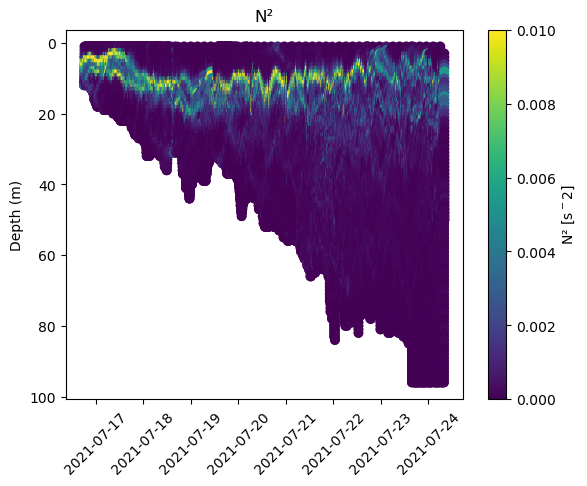

In [7]:
z = plt.scatter(mdates.num2date(bdf_a.time_num),bdf_a.depth, c = abs(bdf_a.N2), vmin = 0, vmax = 0.010)
plt.gca().invert_yaxis()
plt.colorbar(z, label = 'N\u00b2 [s$^-2$]')
plt.xticks(rotation = 45)
# plt.ylim(0,30)
# plt.title('N\u00b2')
plt.ylabel('Depth (m)')
plt.title('N\u00b2');

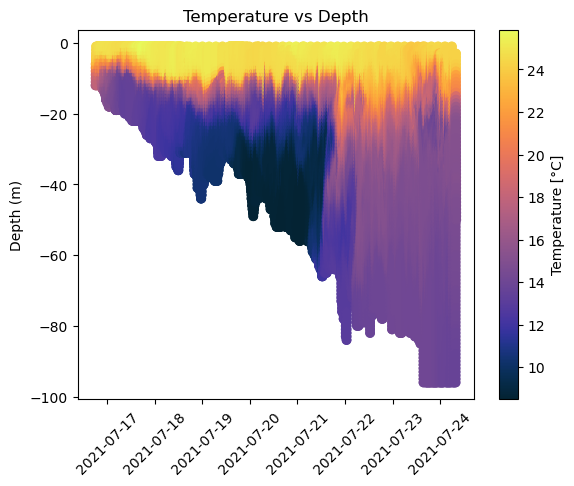

In [8]:
t = plt.scatter(mdates.num2date(bdf_a.time_num), -bdf_a.depth, c = bdf_a.temperature, cmap=cmo.thermal)
plt.colorbar(t, label = 'Temperature [°C]')
plt.xticks(rotation = 45)
plt.title('Temperature vs Depth')
plt.ylabel('Depth (m)');

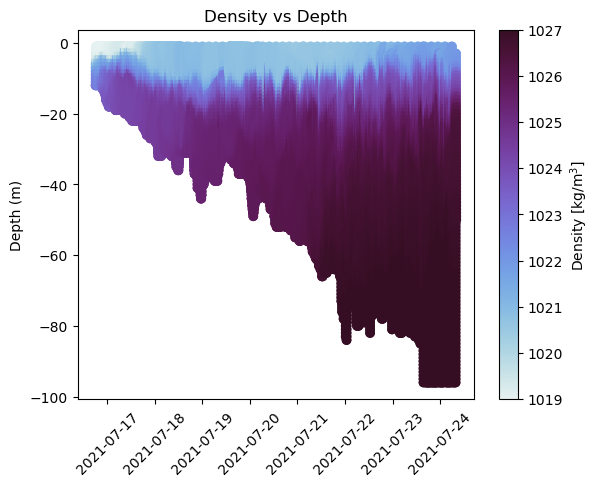

In [9]:
t = plt.scatter(mdates.num2date(bdf_a.time_num), -bdf_a.depth, c = bdf_a.density, cmap=cmo.dense, vmin =1019, vmax=1027)
plt.colorbar(t, label = 'Density [kg/m$^3$]')
plt.xticks(rotation = 45)
plt.title('Density vs Depth')
plt.ylabel('Depth (m)');

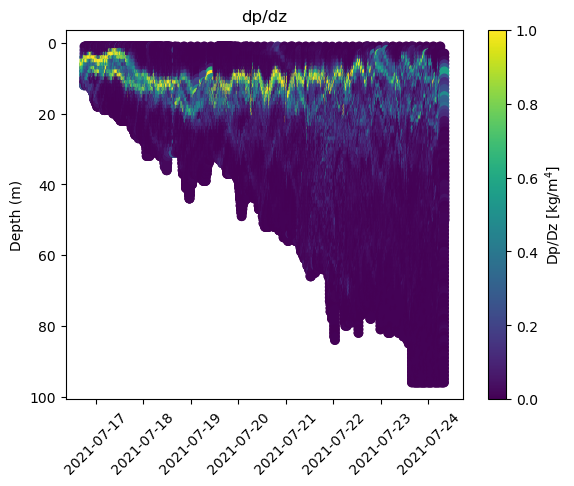

In [10]:
d = plt.scatter(mdates.num2date(bdf_a.time_num),bdf_a.depth, c = abs(bdf_a.dpdz), vmin = 0, vmax = 1)
plt.gca().invert_yaxis()
plt.colorbar(d, label = 'Dp/Dz [kg/m$^4$]')
plt.xticks(rotation = 45)
plt.title('Dp/dz v Depth')
plt.ylabel('Depth (m)')
plt.title('dp/dz');